## Imported Libraries


*   Necessary imports are here



In [39]:
import json
import pandas as pd
from datetime import datetime
from google.colab import files
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

## Importing Data

In [4]:
uploaded = files.upload()

Saving location-history.json to location-history.json


## Loading and extracting the dataset


*   I loaded my Google Maps Timeline from Google Takeout
*   Orginal data has a wide time range so we reduced that range between 8th October 2024 to 9th January 2025



In [31]:
file_path = "location-history.json"
with open(file_path, 'r') as file:
    location_data = json.load(file)

def extract_activity_data(data):
    activity_data = []
    for entry in data:
        if "activity" in entry:
            activity_data.append({
                "Start Time": entry.get("startTime"),
                "End Time": entry.get("endTime"),
                "Start Location": entry["activity"].get("start"),
                "End Location": entry["activity"].get("end"),
                "Place ID": entry.get("placeId"),
                "Mode of Transport": entry["activity"]["topCandidate"].get("type"),
                "Distance (Meters)": float(entry["activity"].get("distanceMeters", 0))
            })
    return activity_data

activity_records = extract_activity_data(location_data)
activity_df = pd.DataFrame(activity_records)

def format_datetime_column(df, column):
    df[column] = pd.to_datetime(df[column], errors='coerce').dt.strftime('%d-%m-%Y %H:%M:%S')
    return df

def format_geolocation_column(df, column):
    df[column] = df[column].str.replace("geo:", "", regex=False)
    return df

activity_df = format_datetime_column(activity_df, "Start Time")
activity_df = format_datetime_column(activity_df, "End Time")
activity_df = format_geolocation_column(activity_df, "Start Location")
activity_df = format_geolocation_column(activity_df, "End Location")

start_date = "08-10-2024 00:00:00"
end_date = "09-01-2025 23:59:59"

activity_df["Start Time"] = pd.to_datetime(activity_df["Start Time"], format='%d-%m-%Y %H:%M:%S', errors='coerce')
activity_df["End Time"] = pd.to_datetime(activity_df["End Time"], format='%d-%m-%Y %H:%M:%S', errors='coerce')

filtered_activity_df = activity_df[
    (activity_df["Start Time"] >= pd.to_datetime(start_date, format='%d-%m-%Y %H:%M:%S')) &
    (activity_df["End Time"] <= pd.to_datetime(end_date, format='%d-%m-%Y %H:%M:%S'))
]

if "Place ID" in filtered_activity_df.columns:
    filtered_activity_df = filtered_activity_df.drop(columns=["Place ID"])

def create_condensed_table(df):
    if len(df) > 8:
        first_rows = df.head(4)
        last_rows = df.tail(4)
        first_rows.index = range(1, 5)
        last_rows.index = range(len(df) - 3, len(df) + 1)

        separator = pd.DataFrame([["..."] * len(df.columns)], columns=df.columns, index=["..."])

        condensed_table = pd.concat([first_rows, separator, last_rows], axis=0)
    else:
        condensed_table = df
        condensed_table.index = range(1, len(df) + 1)
    return condensed_table

condensed_df = create_condensed_table(filtered_activity_df)

def display_visual_table(df, caption="Filtered Travel Activity Data Table"):
    styled_df = df.fillna("").style.set_table_attributes("style='display:inline'").set_caption(caption)
    display(styled_df)

display_visual_table(condensed_df)

,Start Time,End Time,Start Location,End Location,Mode of Transport,Distance (Meters)
1,2024-10-09 14:00:59,2024-10-09 14:41:43,"40.940975,29.322564","40.891434,29.378690",in passenger vehicle,11136.980469
2,2024-10-09 19:10:28,2024-10-09 19:11:43,"40.891746,29.378118","40.892089,29.377912",walking,42.232712
3,2024-10-09 19:11:43,2024-10-09 20:10:34,"40.995004,29.148644","41.007792,29.046911",in passenger vehicle,10893.781250
4,2024-10-09 20:24:09,2024-10-09 20:27:20,"41.007735,29.049592","41.002470,29.056413",in passenger vehicle,1031.801636
...,...,...,...,...,...,...
267,2025-01-09 01:58:46,2025-01-09 02:02:40,"40.864937,29.378115","40.892455,29.378665",in passenger vehicle,3892.291260
268,2025-01-09 03:48:20,2025-01-09 04:22:37,"40.885912,29.322885","41.002981,29.057252",in passenger vehicle,19656.587891
269,2025-01-09 05:02:32,2025-01-09 16:27:19,"41.002848,29.058126","41.001731,29.057971",walking,598.808350
270,2025-01-09 16:27:19,2025-01-09 17:26:13,"40.994052,29.165459","40.892475,29.378387",in passenger vehicle,23259.431641


## Plotting Travel Path


*   Visualising my travel path using scatter plot.



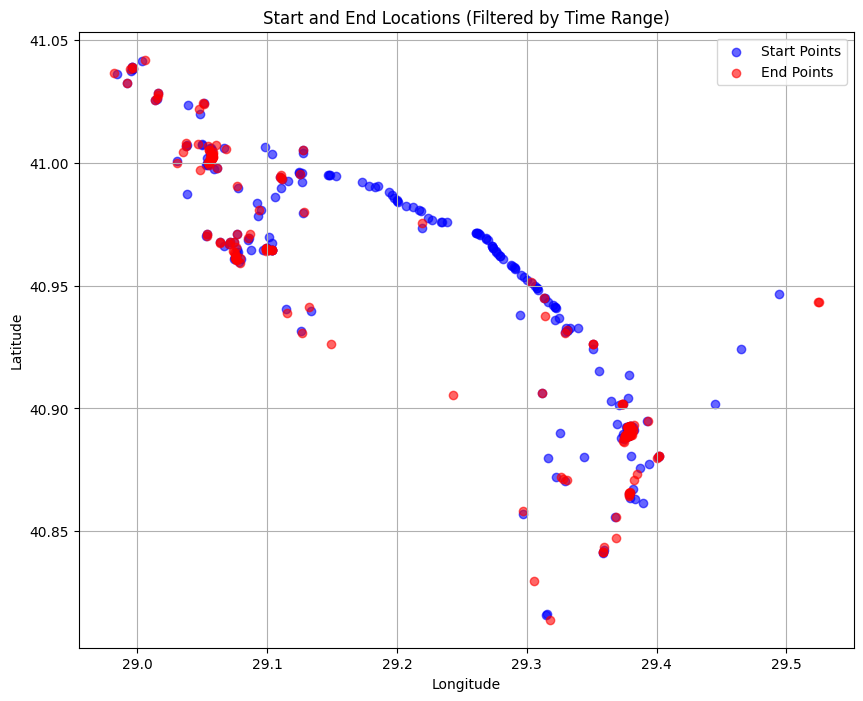

In [33]:
start_date = "2024-10-08"
end_date = "2025-01-09"

filtered_df = activity_df[
    (pd.to_datetime(activity_df["Start Time"], dayfirst=True) >= pd.to_datetime(start_date)) &
    (pd.to_datetime(activity_df["End Time"], dayfirst=True) <= pd.to_datetime(end_date))
].copy()

def parse_coordinates(coord):
    if coord:
        lat, lng = map(float, coord.split(","))
        return lat, lng
    return None, None

filtered_df["Start Lat"], filtered_df["Start Lng"] = zip(*filtered_df["Start Location"].apply(parse_coordinates))
filtered_df["End Lat"], filtered_df["End Lng"] = zip(*filtered_df["End Location"].apply(parse_coordinates))

plt.figure(figsize=(10, 8))

plt.scatter(filtered_df["Start Lng"], filtered_df["Start Lat"], c="blue", label="Start Points", alpha=0.6)

plt.scatter(filtered_df["End Lng"], filtered_df["End Lat"], c="red", label="End Points", alpha=0.6)

plt.title("Start and End Locations (Filtered by Time Range)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid()

plt.show()

## Transport Type Summary


*   Categorizing means of transportation I used while travelling.



Transport Summary (All Categories):
in bus: 47064.23 meters (2.1%)
in passenger vehicle: 2126951.66 meters (94.3%)
walking: 37249.09 meters (1.7%)

Details of 'Other' category:
  - cycling: 3901.44 meters (0.2%)
  - in ferry: 17228.97 meters (0.8%)
  - in subway: 14368.19 meters (0.6%)
  - in train: 8033.85 meters (0.4%)


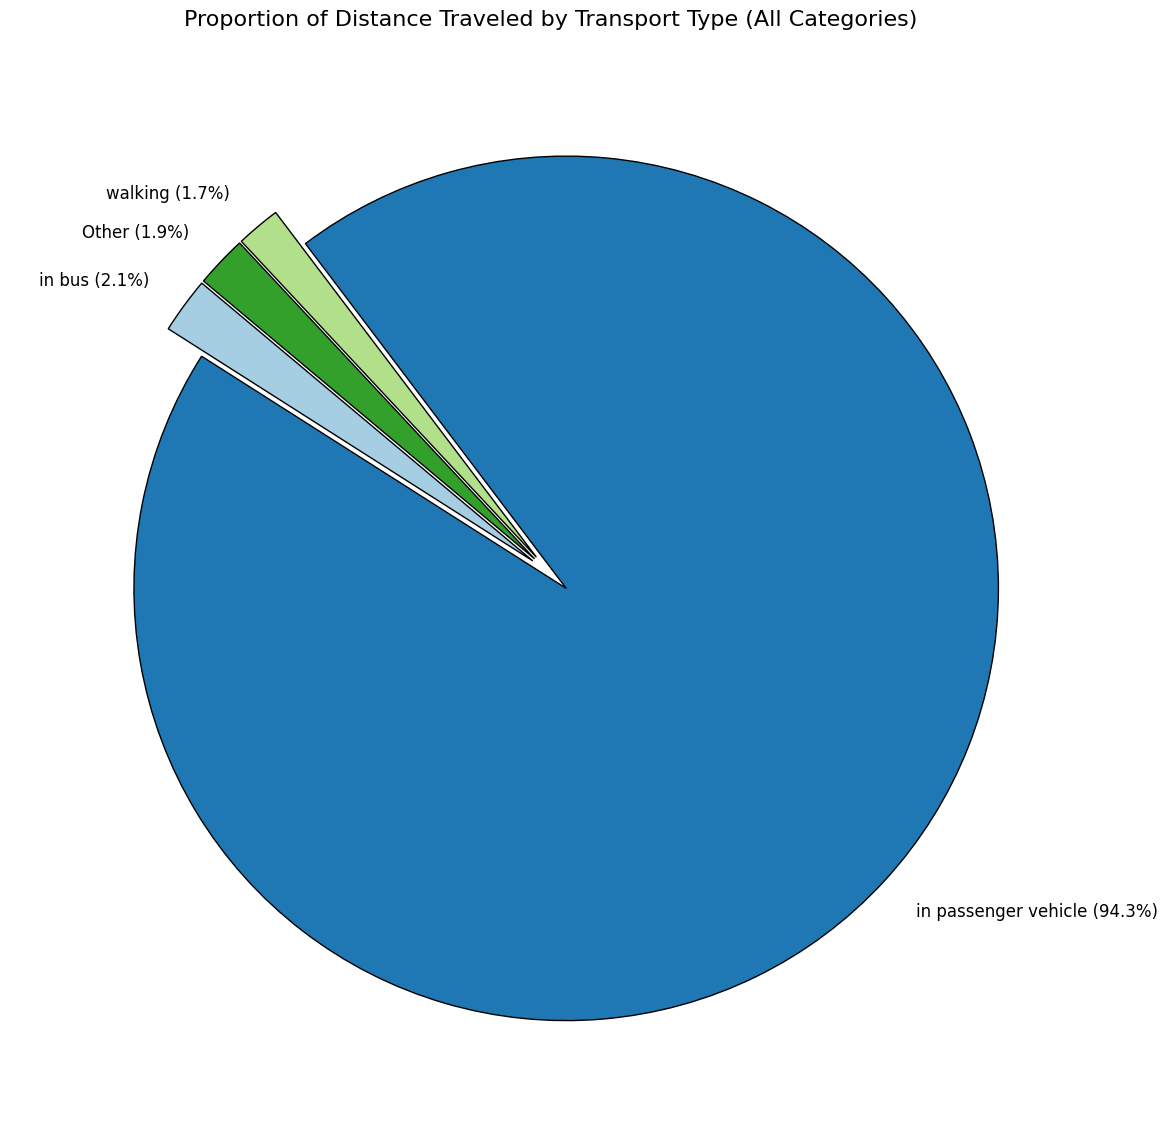

In [34]:
filtered_activity_df = activity_df[
    (activity_df["Start Time"] >= start_date) & (activity_df["End Time"] <= end_date)
].copy()

filtered_activity_df["Mode of Transport"] = filtered_activity_df["Mode of Transport"].fillna("Unknown")

transport_summary = filtered_activity_df.groupby("Mode of Transport")["Distance (Meters)"].sum().reset_index()

total_distance = transport_summary["Distance (Meters)"].sum()
transport_summary["Percentage"] = (transport_summary["Distance (Meters)"] / total_distance) * 100

threshold = 1
minor_segments = transport_summary[transport_summary["Percentage"] < threshold]
major_segments = transport_summary[transport_summary["Percentage"] >= threshold]

if not minor_segments.empty:
    other_row = pd.DataFrame({
        "Mode of Transport": ["Other"],
        "Distance (Meters)": [minor_segments["Distance (Meters)"].sum()],
        "Percentage": [minor_segments["Percentage"].sum()]
    })
    transport_summary = pd.concat([major_segments, other_row], ignore_index=True)

print("Transport Summary (All Categories):")
for _, row in transport_summary.iterrows():
    if row['Mode of Transport'] == "Other":
        print("\nDetails of 'Other' category:")
        for _, minor_row in minor_segments.iterrows():
            print(f"  - {minor_row['Mode of Transport']}: {minor_row['Distance (Meters)']:.2f} meters ({minor_row['Percentage']:.1f}%)")
    else:
        print(f"{row['Mode of Transport']}: {row['Distance (Meters)']:.2f} meters ({row['Percentage']:.1f}%)")

explode_values = [0.05] * len(transport_summary)

plt.figure(figsize=(12, 12))
plt.pie(
    transport_summary["Distance (Meters)"],
    labels=[
        f"{mode} ({percentage:.1f}%)"
        for mode, percentage in zip(transport_summary["Mode of Transport"], transport_summary["Percentage"])
    ],
    autopct=None,
    explode=explode_values,
    startangle=140,
    colors=plt.cm.Paired.colors,
    textprops={'fontsize': 12},
    wedgeprops={"edgecolor": "black", "linewidth": 1}
)
plt.title("Proportion of Distance Traveled by Transport Type (All Categories)", fontsize=16)
plt.tight_layout()
plt.show()

## Average Distance Traveled by Day

Descriptive Statistics for Daily Distance:
count       94.000000
mean     23987.206860
std      22181.888280
min          0.000000
max      83088.764679


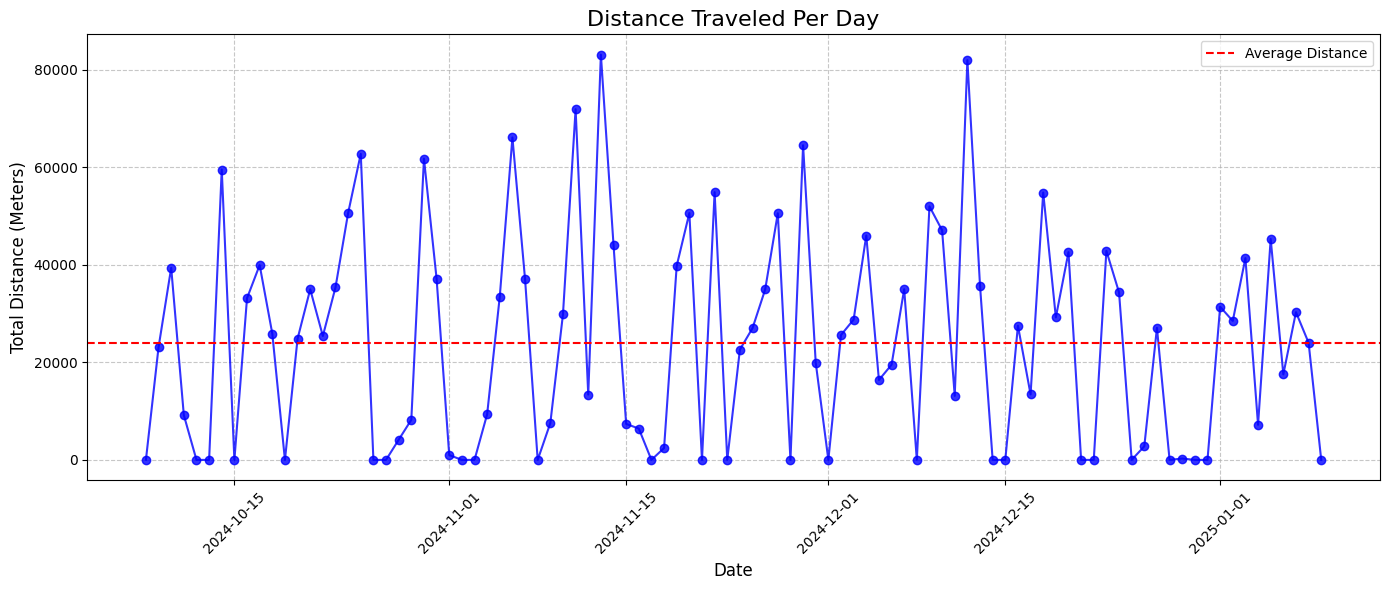

In [35]:
distance_stats = daily_distance["Distance (Meters)"].describe()

print("Descriptive Statistics for Daily Distance:")
print(distance_stats.loc[["count", "mean", "std", "min", "max"]].to_string())

plt.figure(figsize=(14, 6))
plt.plot(daily_distance["Date"], daily_distance["Distance (Meters)"], marker='o', color="blue", linestyle='-', alpha=0.8)
plt.title("Distance Traveled Per Day", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Distance (Meters)", fontsize=12)
plt.axhline(daily_distance["Distance (Meters)"].mean(), color="red", linestyle="--", label="Average Distance")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Average Speed by Day (km/h)

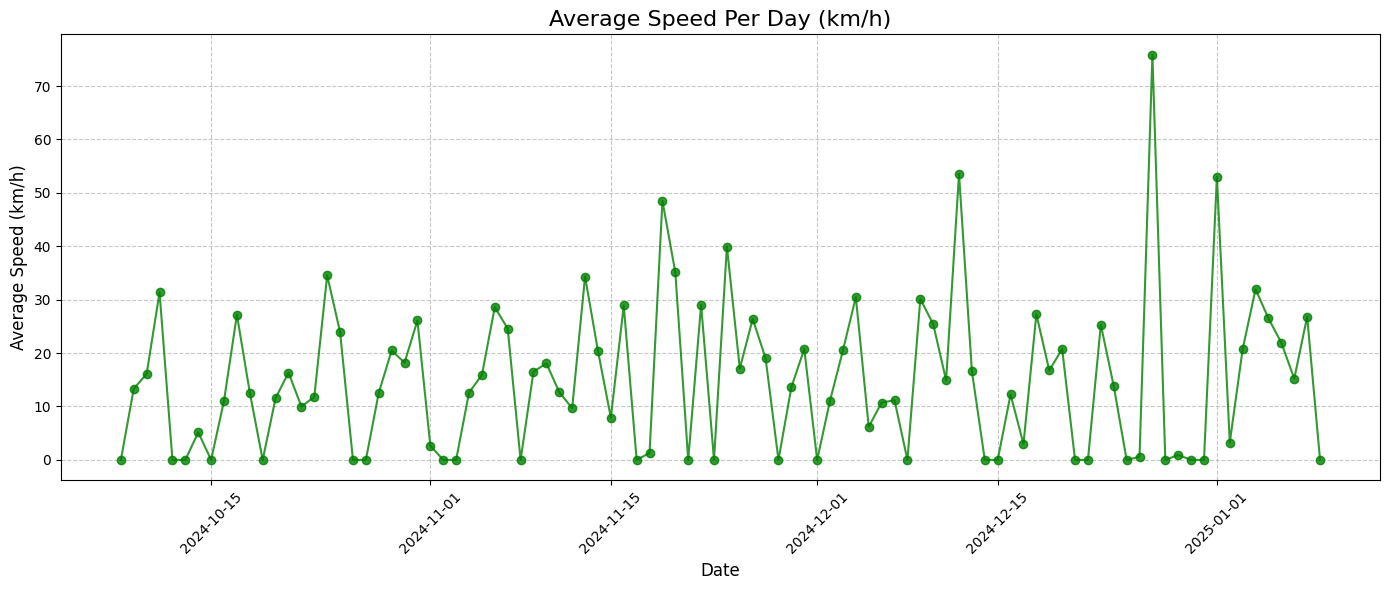

In [74]:
filtered_activity_df["Date"] = filtered_activity_df["Start Time"].dt.date

filtered_activity_df["Duration (Seconds)"] = (
    (filtered_activity_df["End Time"] - filtered_activity_df["Start Time"]).dt.total_seconds()
)

filtered_activity_df = filtered_activity_df[
    (filtered_activity_df["Duration (Seconds)"] > 0) &
    (filtered_activity_df["Duration (Seconds)"] <= 12 * 3600)
]

daily_summary = filtered_activity_df.groupby("Date").agg(
    Total_Distance=("Distance (Meters)", "sum"),
    Total_Time=("Duration (Seconds)", "sum")
).reset_index()

full_date_range = pd.date_range(start=start_date, end=end_date, freq="D")

daily_summary = daily_summary.set_index("Date").reindex(full_date_range, fill_value=0).reset_index()
daily_summary.columns = ["Date", "Total_Distance", "Total_Time"]

daily_summary["Average Speed (km/h)"] = daily_summary.apply(
    lambda row: (row["Total_Distance"] / row["Total_Time"]) * 3.6 if row["Total_Time"] > 0 else 0, axis=1
)

plt.figure(figsize=(14, 6))
plt.plot(
    daily_summary["Date"],
    daily_summary["Average Speed (km/h)"],
    marker='o',
    color="green",
    linestyle='-',
    alpha=0.8
)
plt.title("Average Speed Per Day (km/h)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Speed (km/h)", fontsize=12)
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Daily Travel Time

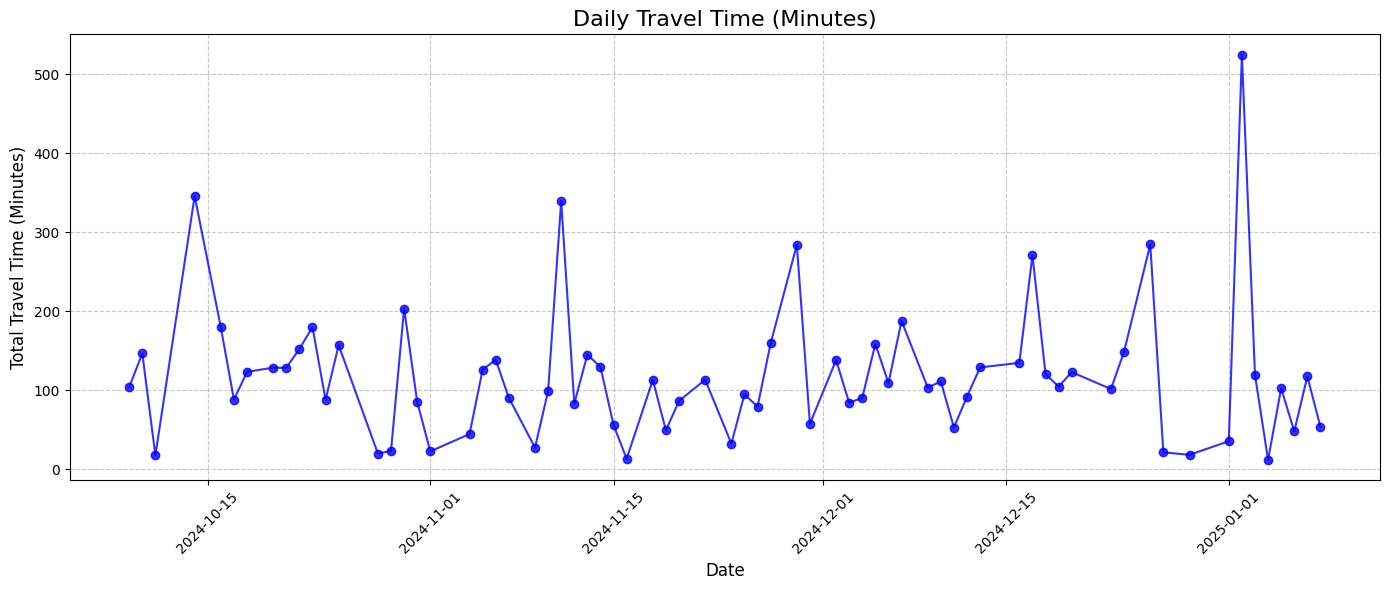

In [73]:
filtered_activity_df["Duration (Seconds)"] = (
    (filtered_activity_df["End Time"] - filtered_activity_df["Start Time"]).dt.total_seconds()
)

filtered_activity_df = filtered_activity_df[
    (filtered_activity_df["Duration (Seconds)"] > 0) &
    (filtered_activity_df["Duration (Seconds)"] <= 8 * 3600)
]

daily_travel_time = (
    filtered_activity_df.groupby(filtered_activity_df["Start Time"].dt.date)["Duration (Seconds)"]
    .sum()
    .reset_index()
)
daily_travel_time.columns = ["Date", "Total Travel Time (Seconds)"]

daily_travel_time["Total Travel Time (Minutes)"] = daily_travel_time["Total Travel Time (Seconds)"] / 60

plt.figure(figsize=(14, 6))
plt.plot(
    daily_travel_time["Date"],
    daily_travel_time["Total Travel Time (Minutes)"],
    marker="o",
    color="blue",
    linestyle="-",
    alpha=0.8,
)
plt.title("Daily Travel Time (Minutes)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Travel Time (Minutes)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Average Distance Traveled by Day of the Week

<ipython-input-71-5f73aabec40a>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


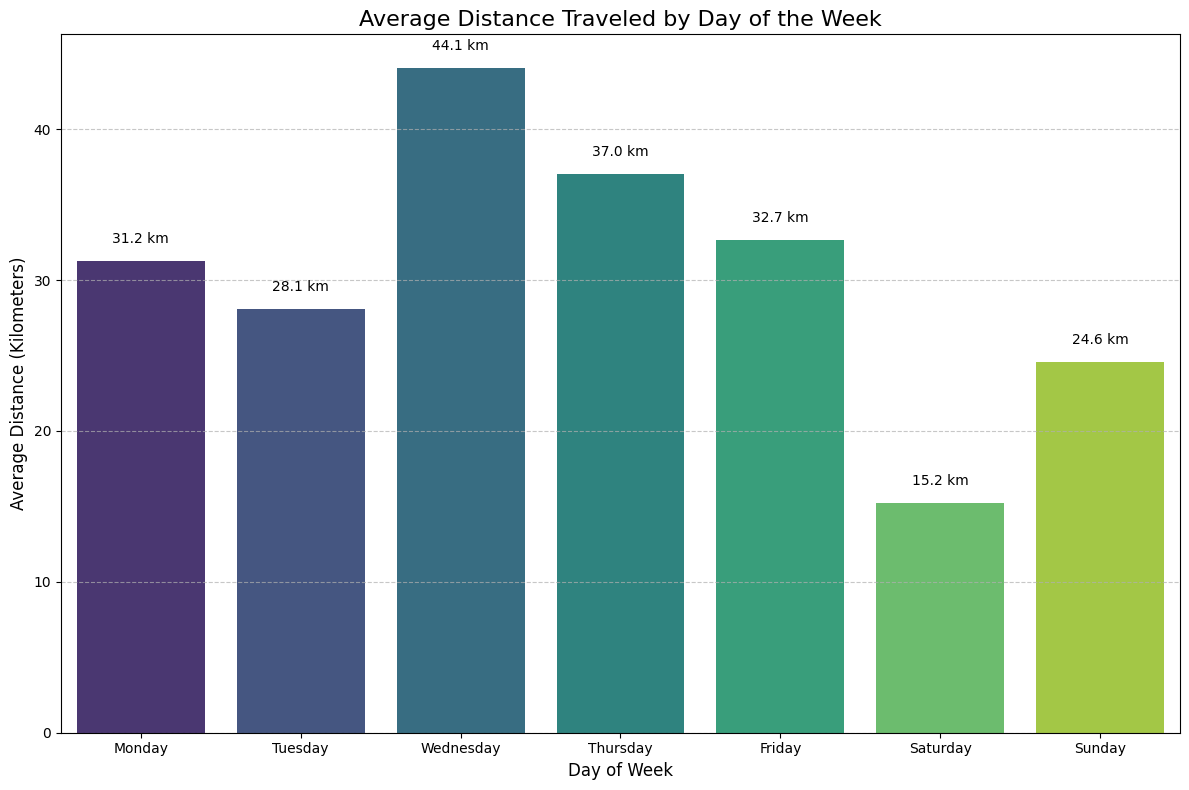

In [71]:
filtered_activity_df["Day of Week"] = pd.to_datetime(filtered_activity_df["Start Time"]).dt.day_name()

day_occurrences = (
    filtered_activity_df.groupby("Day of Week")["Date"]
    .nunique()
    .reset_index()
    .rename(columns={"Date": "Occurrences"})
)

total_distance_by_day = (
    filtered_activity_df.groupby("Day of Week")["Distance (Meters)"]
    .sum()
    .reset_index()
    .rename(columns={"Distance (Meters)": "Total Distance (Meters)"})
)

average_distance_by_day = pd.merge(total_distance_by_day, day_occurrences, on="Day of Week")

average_distance_by_day["Average Distance (Meters)"] = (
    average_distance_by_day["Total Distance (Meters)"] / average_distance_by_day["Occurrences"]
)

average_distance_by_day["Average Distance (Kilometers)"] = average_distance_by_day["Average Distance (Meters)"] / 1000

days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
average_distance_by_day["Day of Week"] = pd.Categorical(
    average_distance_by_day["Day of Week"], categories=days_order, ordered=True
)
average_distance_by_day = average_distance_by_day.sort_values("Day of Week").reset_index(drop=True)

plt.figure(figsize=(12, 8))
sns.barplot(
    x="Day of Week",
    y="Average Distance (Kilometers)",
    data=average_distance_by_day,
    palette="viridis"
)

for i, row in average_distance_by_day.iterrows():
    plt.text(
        i,
        row["Average Distance (Kilometers)"] + 1,
        f"{row['Average Distance (Kilometers)']:.1f} km",
        color="black",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.title("Average Distance Traveled by Day of the Week", fontsize=16)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Average Distance (Kilometers)", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

plt.show()

## ML Model to Predict Future Average Distance Traveled by Day of the Week

In [54]:
filtered_activity_df["Date"] = pd.to_datetime(filtered_activity_df["Start Time"]).dt.date
filtered_activity_df["Day of Week"] = pd.to_datetime(filtered_activity_df["Start Time"]).dt.dayofweek

daily_summary = filtered_activity_df.groupby(["Date", "Day of Week"]).agg(
    Total_Distance=("Distance (Meters)", "sum")
).reset_index()

daily_summary["Total_Distance_km"] = daily_summary["Total_Distance"] / 1000

X = daily_summary[["Day of Week"]]
y = daily_summary["Total_Distance_km"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE: {rmse:.2f} km")

future_days = pd.DataFrame({"Day of Week": [0, 1, 2, 3, 4, 5, 6]})
future_predictions = model.predict(future_days)

print("\nPredicted Travel Distances for Each Day of the Week:")
for day, pred in zip(future_days["Day of Week"], future_predictions):
    print(f"Day {day} (0=Monday, 6=Sunday): {pred:.2f} km")


RMSE: 17.83 km

Predicted Travel Distances for Each Day of the Week:
Day 0 (0=Monday, 6=Sunday): 34.24 km
Day 1 (0=Monday, 6=Sunday): 24.98 km
Day 2 (0=Monday, 6=Sunday): 47.02 km
Day 3 (0=Monday, 6=Sunday): 34.86 km
Day 4 (0=Monday, 6=Sunday): 27.66 km
Day 5 (0=Monday, 6=Sunday): 17.50 km
Day 6 (0=Monday, 6=Sunday): 24.58 km
